In [ ]:
%pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 13.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import re
import time
import emoji
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.auto import tqdm
import tensorflow as tf
#%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Dense, Input, LSTM, Embedding, Dropout, Activation,
    Bidirectional, GlobalMaxPool1D
)
from tensorflow.keras.models import Model

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
TRAIN_DATA_PATH = '/content/train.csv'
TEST_DATA_PATH = '/content/test.csv'
SAVED_MODEL_PATH = '/content/model.keras'
VOCAB_SIZE = 10000  # Vocabulary size for tokenizer
EMBEDDING_DIM = 100  # Embedding dimension for LSTM
MAX_LEN = 128  # Maximum sequence length
BATCH_SIZE = 32
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5

print("Configuration Loaded Successfully!")

Configuration Loaded Successfully!


In [ ]:
def clean_text(text):
    """Cleans text by removing emojis, special characters, lowercasing, stemming, and lemmatizing."""
    text = emoji.replace_emoji(text, replace="")
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = " ".join(text.split())
    words = text.split()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word.lower() not in stop_words]
    return " ".join(words)

In [ ]:
data = pd.read_csv(TRAIN_DATA_PATH).drop_duplicates()
data = data.dropna(subset=['text'])
data = data[data['style'] != 'formality']  # Drop rows where style is 'formality'
data = data[data['label_text'] != 'neutral']
print(f'Number of samples after dropping NaN and "formality" style: {len(data)}')
data.head()
print(data['label_text'].value_counts())

Number of samples after dropping NaN and "formality" style: 77616
label_text
positive         33361
negative         27711
very positive     9311
very negative     7233
Name: count, dtype: int64


In [ ]:
data2 = pd.read_csv(TEST_DATA_PATH).drop_duplicates()
data2 = data2.dropna(subset=['text'])
data2 = data2[data2['style'] != 'formality']  # Drop rows where style is 'formality'
data2 = data2[data2['label_text'] != 'neutral']
print(f'Number of samples after dropping NaN and "formality" style: {len(data2)}')
data2.head()
print(data2['label_text'].value_counts())

Number of samples after dropping NaN and "formality" style: 1821
label_text
negative         633
positive         510
very positive    399
very negative    279
Name: count, dtype: int64


In [ ]:
data['label_text'] = data['label_text'].apply(
    lambda x: 0 if x in ['very negative', 'negative'] else 1
)
data.head()

data2['label_text'] = data2['label_text'].apply(
    lambda x: 0 if x in ['very negative', 'negative'] else 1
)


<ipython-input-10-b716760a60a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_text'] = data['label_text'].apply(


In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data))
list_tokenized_train = tokenizer.texts_to_sequences(data)
list_tokenized_test = tokenizer.texts_to_sequences(data)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
maxlen = 100
num_words = 10000  # or any vocab size you want

data['cleaned_text'] = data['text'].apply(clean_text)

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(data['text'])
X_test = tokenizer.texts_to_sequences(data2['text'])

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [ ]:
from tensorflow.keras.layers import Input, Embedding

embed_size = 128

inp = Input(shape=(maxlen,))
x = Embedding(input_dim=max_features, output_dim=embed_size)(inp)

In [ ]:
# Input and Embedding
inp = Input(shape=(maxlen,))
x = Embedding(input_dim=max_features, output_dim=embed_size)(inp)

# LSTM Layer
output_dimention = 60
x = LSTM(output_dimention, return_sequences=True, name='lstm_layer')(x)

# Reduce dimensionality
x = GlobalMaxPool1D()(x)

# Dropout and Dense layers
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)

# Output layer for binary classification
x = Dense(1, activation="sigmoid")(x)

In [ ]:
y_train = data['label_text'].values
y_test = data2['label_text'].values

In [ ]:
model = Model(inputs=inp, outputs=x)
# we use binary_crossentropy because of binary classification
# optimise loss by Adam optimiser
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Training Model...')
start_fitting = time.time()
model.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.1)
fitting_model_time = time.time()
print('Training Model took: ', fitting_model_time - start_fitting)

Training Model...
Epoch 1/5
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.7659 - loss: 0.4528 - val_accuracy: 0.8203 - val_loss: 0.4086
Epoch 2/5
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9190 - loss: 0.1969 - val_accuracy: 0.8382 - val_loss: 0.3952
Epoch 3/5
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9473 - loss: 0.1335 - val_accuracy: 0.8204 - val_loss: 0.4343
Epoch 4/5
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9557 - loss: 0.1059 - val_accuracy: 0.8020 - val_loss: 0.4809
Epoch 5/5
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9633 - loss: 0.0849 - val_accuracy: 0.8080 - val_loss: 0.5472
Training Model took:  138.48980140686035


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[1 1 1 ... 1 1 0]
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
Confusion Matrix:
[[729 183]
 [117 792]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       912
           1       0.81      0.87      0.84       909

    accuracy                           0.84      1821
   macro avg       0.84      0.84      0.84      1821
weighted avg       0.84      0.84      0.84      1821



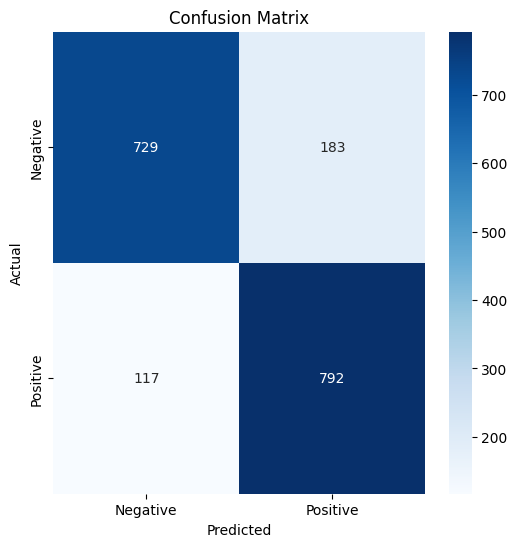

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation data (or test data if available)
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert predictions to 0 or 1 based on threshold

print(y_test)
print(y_pred)
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model to a file
model.save("LSTM.keras")